## Libraries

`torchvision.datasets` contains some popular datasets for computer vision.

`torchvision.models` contains some popular architectures for computer vision.

`torchvision.transforms` contains common image transformations.

`torch.utils.data.Dataset` is an abstract class representing a dataset.

`torch.utils.data.DataLoader` wraps a dataset and provides access to the underlying data.

In [33]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


## import dataset

In [34]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)

print(len(train_data))
print(len(test_data))

60000
10000


In [35]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [36]:
class_to_idx = train_data.class_to_idx
print(class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [37]:
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [38]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

## Visualizing data

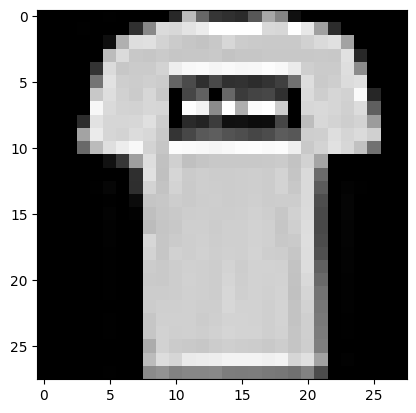

In [39]:
image, label = train_data[1]
plt.imshow(image.squeeze(), cmap="gray")

## Dataloaders

turns the data into an iterable object

In [43]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataloader), len(test_dataloader))

1875 313


In [45]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape, train_labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


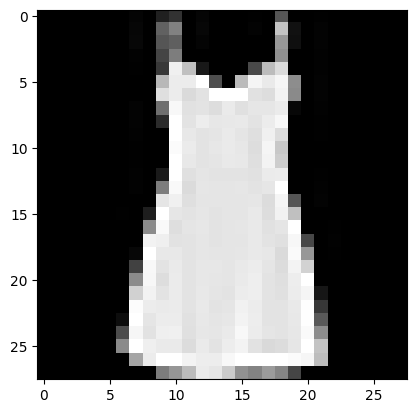

In [48]:
random_idx = torch.randint(0, len(train_features), (1,)).item()
img, label = train_features[random_idx], train_labels[random_idx]
plt.imshow(img.squeeze(), cmap="gray")